In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
eps=1e-9

1.0e-9

# 1-d example

In [3]:
s = 0.3
F_matrix = [0 1; -1 0]

function gd_discrete(ini_solution, num_iter, s=0.3)
#   s = 0.3
  solutions = zeros(2, num_iter)
  current_solution = copy(ini_solution)
  for i in 1:num_iter
    solutions[:,i] = current_solution
    next_solution = copy(current_solution)
    next_solution -= s*F_matrix*current_solution
    current_solution = copy(next_solution)
  end
  return solutions
end

function new_discrete(ini_solution, num_iter, s=0.3)
#   s = 0.3
  solutions = zeros(2, num_iter)
  current_solution = copy(ini_solution)
  for i in 1:num_iter
    solutions[:,i] = current_solution
    next_solution = copy(current_solution)
    next_solution += s*F_matrix*F_matrix*current_solution
    current_solution = copy(next_solution)
  end
  return solutions
end

function egd_discrete(ini_solution, num_iter, s=0.3)
#   s = 0.3
  solutions = zeros(2, num_iter)
  current_solution = copy(ini_solution)
  for i in 1:num_iter
    solutions[:,i] = current_solution
    middle_solution = copy(current_solution)
    middle_solution -= s*F_matrix*current_solution
    next_solution = copy(current_solution)
    next_solution -= s*F_matrix*middle_solution
    current_solution = copy(next_solution)
  end
  return solutions
end

function pdhg_discrete(ini_solution, num_iter, s=0.3)
#   s = 0.3
  solutions = zeros(2, num_iter)
  current_solution = copy(ini_solution)
  for i in 1:num_iter
    solutions[:,i] = current_solution
    next_solution = copy(current_solution)
    next_solution[1] -= s*next_solution[2]
    next_solution[2] += s*(2*next_solution[1]-current_solution[1])
    current_solution = copy(next_solution)
  end
  return solutions
end

pdhg_discrete (generic function with 2 methods)

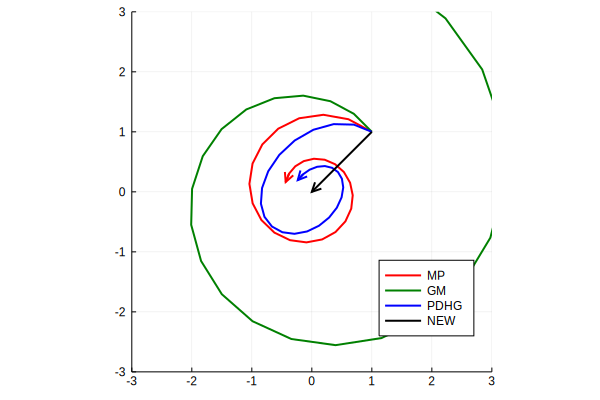

In [4]:
x0 = [1.0;1.0]
tspan = (0.0,8.0)
solutions_gd = gd_discrete(x0, Int(ceil(tspan[2]/s)))
solutions_egd = egd_discrete(x0, Int(ceil(tspan[2]/s)))
solutions_pdhg = pdhg_discrete(x0, Int(ceil(tspan[2]/s)))
solutions_new = new_discrete(x0, Int(ceil(tspan[2]/s)))
xylim=3

plot(solutions_egd[1,:], solutions_egd[2,:], color=:red, linewidth=2, label="MP", arrow=0.5,legend=:bottomright, aspect_ratio=:equal)
plot!(solutions_gd[1,:], solutions_gd[2,:], color=:green, linewidth=2, label="GM", arrow=0.5,legend=:bottomright, aspect_ratio=:equal)
plot!(solutions_pdhg[1,:], solutions_pdhg[2,:], color=:blue, linewidth=2, label="PDHG", arrow=0.5,legend=:bottomright, aspect_ratio=:equal)
plot!(solutions_new[1,:], solutions_new[2,:], color=:black, linewidth=2, label="NEW", arrow=0.5,legend=:bottomright, aspect_ratio=:equal)


xlims!((-xylim,xylim))
ylims!((-xylim,xylim))
# savefig("new_")

# 2d Unconstrainted Example

In [5]:
s = 0.1
A = [1 2; 3 1]
c = [-2;1]
b=[1;1]
ini_solution=[1.0;2;0;0]
num_iter=200

200

In [6]:
function lyapunov(solution, A, c, b)
    primal_gradient = A*solution[3:4]+c
    dual_gradient = -A*solution[1:2]+b
    lyapunov_value = 0
    for idx in 1:2
        if solution[idx] <= 0 && primal_gradient[idx] >= 0
            continue
        end
        lyapunov_value += primal_gradient[idx]^2
    end
    for idx in 1:2
        if solution[idx+2] <= 0 && dual_gradient[idx] >= 0
            continue
        end
        lyapunov_value += dual_gradient[idx]^2
    end
    return lyapunov_value
end

lyapunov (generic function with 1 method)

In [7]:
function new_discrete(ini_solution, num_iter, A, c, b, s)
    n = length(c)
    m = length(b)
    F_matrix = zeros(m+n, m+n)
    F_matrix[1:n, n+1:end] = A
    F_matrix[n+1:end, 1:n] = -A'
    solutions = zeros(m+n, num_iter)
    current_solution = copy(ini_solution)
    for i in 1:num_iter
        solutions[:,i] = current_solution
        next_solution = copy(current_solution)
#         print(F_matrix*current_solution+[c;b])
#         println(current_solution)
        next_solution += s*F_matrix*(F_matrix*current_solution+[c;b])
#         next_solution[next_solution.<0.] .= 0
        current_solution = copy(next_solution)
    end
    return solutions
end

new_discrete (generic function with 3 methods)

In [14]:
function egd_discrete(ini_solution, num_iter, A, c, b, s)
    n = length(c)
    m = length(b)
    F_matrix = zeros(m+n, m+n)
    F_matrix[1:n, n+1:end] = A
    F_matrix[n+1:end, 1:n] = -A'
    solutions = zeros(m+n, num_iter)
    current_solution = copy(ini_solution)
    for i in 1:num_iter
        solutions[:,i] = current_solution
        middle_solution = copy(current_solution)
        middle_solution -= s*(F_matrix*current_solution+[c;b])
#         middle_solution[middle_solution.<0.] .= 0
        next_solution = copy(current_solution)
        next_solution -= s*(F_matrix*middle_solution+[c;b])
        next_solution[next_solution.<0.] .= 0
        current_solution = copy(next_solution)
    end
    return solutions
end

egd_discrete (generic function with 3 methods)

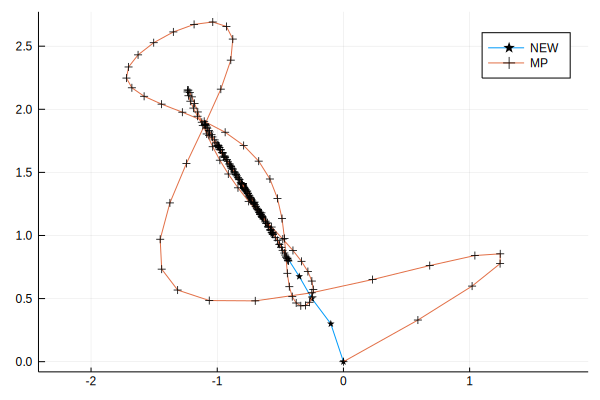

In [9]:
solutions_new = new_discrete(ini_solution, num_iter, A, c, b, s)
plot(solutions_new[3,:], solutions_new[4,:], markershape=:star, markercolor=:black, axis=true, aspect_ratio=:equal, label="NEW")
solutions_egd = egd_discrete(ini_solution, num_iter, A, c, b, s)
plot!(solutions_egd[3,:], solutions_egd[4,:], markershape=:+, markercolor=:black, axis=true, label="MP")

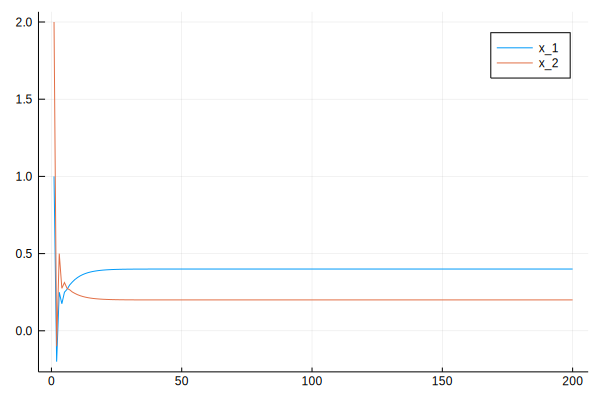

In [10]:
plot(solutions_new[1,:], label="x_1")
plot!(solutions_new[2,:], label="x_2")

# 1d Constrainted Example

$max_{y\ge 0} min_{x\ge 0} y'Ax+c'x-b'y$

In [62]:
s = 0.05
# A = [1]
A = Matrix{Int}(I, 1, 1)
c = [1]
b=[2]
ini_solution=[1;1]
num_iter=50

50

In [63]:
function lyapunov(solution, A, c, b)
    n = length(c)
    m = length(b)
    F_matrix = zeros(m+n, m+n)
    F_matrix[1:n, n+1:end] = A
    F_matrix[n+1:end, 1:n] = -A'
    middle_term = F_matrix*solution+[c;b]

    lyapunov_value = 0
    for idx in 1:(m+n)
        if solution[idx] <= eps && middle_term[idx] >= -eps
            continue
        end
        lyapunov_value += middle_term[idx]^2
    end
    return lyapunov_value
end

lyapunov (generic function with 1 method)

In [66]:
function new_discrete(ini_solution, num_iter, A, c, b, s)
    n = length(c)
    m = length(b)
    F_matrix = zeros(m+n, m+n)
    F_matrix[1:n, n+1:end] = A
    F_matrix[n+1:end, 1:n] = -A'
    solutions = zeros(m+n, num_iter)
    current_solution = copy(ini_solution)
    for i in 1:num_iter
        solutions[:,i] = current_solution
        next_solution = copy(current_solution)
        middle_term = F_matrix*current_solution+[c;b]
        indexes = (current_solution.<=eps) .& (F_matrix*middle_term.>=0)
#         ignore_rows = (current_solution.<=eps) .& (middle_term.>=0)
#         println(ignore_rows)
#         temp = copy(F_matrix)
#         temp[ignore_rows,:].=0
#         temp[:,ignore_rows].=0
        middle_term[(current_solution.<=eps) .& (middle_term.>=0)] .= 0
        println(middle_term)
#         @show(current_solution)
#         @show(middle_term)
#         @show(F_matrix*(middle_term))
#         print(F_matrix*current_solution+[c;b])
#         println(current_solution)
        println(lyapunov(current_solution, A, c, b))
        next_solution += s*F_matrix*(middle_term)
        next_solution[next_solution.<=eps] .= 0
        current_solution = copy(next_solution)
    end
    return solutions
end

new_discrete (generic function with 3 methods)

[2.0, 1.0]
5.0
[1.9, 0.95]
4.5125
[1.8050000000000002, 0.9024999999999999]
4.07253125
[1.71475, 0.8573749999999998]
3.6754594531249998
[1.6290125, 0.8145062499999998]
3.317102156445312
[1.547561875, 0.7737809374999998]
2.9936846961918944
[1.47018378125, 0.7350918906249997]
2.7018004383131844
[1.3966745921875, 0.6983372960937497]
2.4383748955776485
[1.326840862578125, 0.6634204312890621]
2.200633343258828
[1.2604988194492188, 0.630249409724609]
1.9860715922910923
[1.1974738784767578, 0.5987369392383786]
1.7924296120427106
[1.13760018455292, 0.5688000922764596]
1.6176677248685465
[1.080720175325274, 0.5403600876626367]
1.4599451216938633
[1.0266841665590103, 0.5133420832795048]
1.3176004723287116
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]
1.0
[1.0, 0.0]


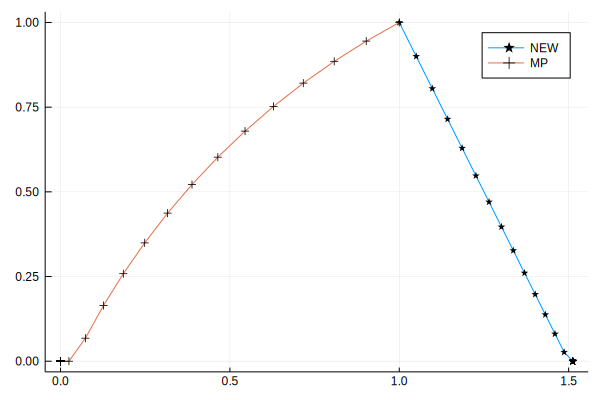

In [67]:
solutions_new = new_discrete(ini_solution, num_iter, A, c, b, s)
plot(solutions_new[1,:], solutions_new[2,:], markershape=:star, markercolor=:black, axis=true, aspect_ratio=:equal, label="NEW")
solutions_egd = egd_discrete(ini_solution, num_iter, A, c, b, s)
plot!(solutions_egd[1,:], solutions_egd[2,:], markershape=:+, markercolor=:black, axis=true, label="MP")
# plot!([0,0],[0,2], linestyle=:dash, linecolor=:green)
# plot!([0,4/3],[2,4/3], linestyle=:dash, linecolor=:green)
# plot!([4/3,2],[4/3,0], linestyle=:dash, linecolor=:green)
# plot!([2,0],[0,0], linestyle=:dash, linecolor=:green)
# xlims!((-1,3))
# ylims!((-1,3))

# 2d Constrainted Example

In [121]:
s = 0.1
A = [1 0; 0 1]
c = [-1;3]
b=[4;4]
ini_solution=[1;0.5;2;3]
num_iter=500

500

In [122]:
# function lyapunov(solution, A, c, b)
#     primal_gradient = A*solution[3:4]+c
#     dual_gradient = -A*solution[1:2]+b
#     lyapunov_value = 0
#     for idx in 1:2
#         if solution[idx] <= eps && primal_gradient[idx] >= -eps
# #             println(idx)
#             continue
#         end
#         lyapunov_value += primal_gradient[idx]^2
#     end
#     for idx in 3:4
#         if solution[idx] <= eps && dual_gradient[idx-2] >= -eps
# #             println(idx)
#             continue
#         end
#         lyapunov_value += dual_gradient[idx]^2
#     end
#     return lyapunov_value
# end

In [123]:
function new_discrete(ini_solution, num_iter, A, c, b, s)
    n = length(c)
    m = length(b)
    F_matrix = zeros(m+n, m+n)
    F_matrix[1:n, n+1:end] = A
    F_matrix[n+1:end, 1:n] = -A'
    solutions = zeros(m+n, num_iter)
    current_solution = copy(ini_solution)
    for i in 1:num_iter
        solutions[:,i] = current_solution
        next_solution = copy(current_solution)
        middle_term = F_matrix*current_solution+[c;b]
        indexes = (current_solution.<=eps) .& (middle_term.>=0)
#         ignore_rows = (current_solution.<=eps) .& (middle_term.>=0)
#         println(ignore_rows)
#         temp = copy(F_matrix)
#         temp[ignore_rows,:].=0
#         temp[:,ignore_rows].=0
        middle_term[(current_solution.<=eps) .& (middle_term.>=0)] .= 0
        println(middle_term)
#         @show(current_solution)
#         @show(middle_term)
#         @show(F_matrix*(middle_term))
#         print(F_matrix*current_solution+[c;b])
#         println(current_solution)
        println(lyapunov(current_solution, A, c, b))
        next_solution += s*F_matrix*(middle_term)
        next_solution[next_solution.<=eps] .= 0
        current_solution = copy(next_solution)
        println(current_solution)
    end
    return solutions
end

new_discrete (generic function with 3 methods)

In [124]:
function egd_discrete(ini_solution, num_iter, A, c, b, s)
    n = length(c)
    m = length(b)
    F_matrix = zeros(m+n, m+n)
    F_matrix[1:n, n+1:end] = A
    F_matrix[n+1:end, 1:n] = -A'
    solutions = zeros(m+n, num_iter)
    current_solution = copy(ini_solution)
    for i in 1:num_iter
        solutions[:,i] = current_solution
        middle_solution = copy(current_solution)
        middle_solution -= s*(F_matrix*current_solution+[c;b])
        middle_solution[middle_solution.<=0] .= 0
        next_solution = copy(current_solution)
        next_solution -= s*(F_matrix*middle_solution+[c;b])
        next_solution[next_solution.<=0] .= 0
        current_solution = copy(next_solution)
#         l_value = lyapunov(current_solution, A, c, b)
#         @show(l_value)
    end
    return solutions
end

egd_discrete (generic function with 3 methods)

In [127]:
solutions_new = new_discrete(ini_solution, num_iter, A, c, b, s)
plot(solutions_new[1,:], solutions_new[2,:], markershape=:star, markercolor=:black, axis=true, aspect_ratio=:equal, label="NEW")
solutions_egd = egd_discrete(ini_solution, num_iter, A, c, b, s)



[1.0, 6.0, 3.0, 3.5]
58.25
[1.3, 0.8500000000000001, 1.9, 2.4]
[0.8999999999999999, 5.4, 2.7, 3.15]
47.182500000000005
[1.57, 1.165, 1.8099999999999998, 1.8599999999999999]
[0.8099999999999998, 4.859999999999999, 2.4299999999999997, 2.835]
38.21782499999999
[1.8130000000000002, 1.4485000000000001, 1.7289999999999999, 1.3739999999999999]
[0.7289999999999999, 4.374, 2.187, 2.5515]
30.956438249999998
[2.0317000000000003, 1.70365, 1.6561, 0.9365999999999999]
[0.6560999999999999, 3.9366, 1.9682999999999997, 2.29635]
25.074714982499998
[2.22853, 1.9332850000000001, 1.59049, 0.5429399999999999]
[0.59049, 3.5429399999999998, 1.7714699999999999, 2.066715]
20.310519135824997
[2.4056770000000003, 2.1399565000000003, 1.531441, 0.18864599999999987]
[0.531441, 3.188646, 1.5943229999999997, 1.8600434999999997]
16.451520500018248
[2.5651093000000005, 2.3259608500000004, 1.4782969000000001, 0.0]
[0.47829690000000014, 3.0, 1.4348906999999995, 0.0]
11.287679245496099
[2.7085983700000003, 2.32596085000000

[0.0008595044557171416, 3.0, 0.002578513367151203, 0.0]
9.000007387479094
[3.997679337969564, 2.3259608500000004, 1.0007735540101454, 0.0]
[0.0007735540101454497, 3.0, 0.002320662030435905, 0.0]
9.000005983858067
[3.9979114041726076, 2.3259608500000004, 1.000696198609131, 0.0]
[0.0006961986091309491, 3.0, 0.0020885958273924032, 0.0]
9.000004846925034
[3.998120263755347, 2.3259608500000004, 1.0006265787482178, 0.0]
[0.0006265787482178098, 3.0, 0.0018797362446529853, 0.0]
9.000003926009278
[3.9983082373798124, 2.3259608500000004, 1.000563920873396, 0.0]
[0.0005639208733960732, 3.0, 0.0016917626201875535, 0.0]
9.000003180067514
[3.9984774136418313, 2.3259608500000004, 1.0005075287860565, 0.0]
[0.0005075287860565325, 3.0, 0.0015225863581687094, 0.0]
9.000002575854687
[3.998629672277648, 2.3259608500000004, 1.000456775907451, 0.0]
[0.0004567759074509681, 3.0, 0.001370327722352016, 0.0]
9.000002086442295
[3.998766705049883, 2.3259608500000004, 1.0004110983167058, 0.0]
[0.00041109831670582686

[3.999998939977495, 2.3259608500000004, 1.0000003533408348, 0.0]
[3.5334083481330936e-7, 3.0, 1.0600225048840173e-6, 0.0]
9.000000000001249
[3.9999990459797456, 2.3259608500000004, 1.0000003180067514, 0.0]
[3.1800675137638734e-7, 3.0, 9.540202543512066e-7, 0.0]
9.00000000000101
[3.999999141381771, 2.3259608500000004, 1.0000002862060762, 0.0]
[2.862060761721352e-7, 3.0, 8.586182289604949e-7, 0.0]
9.000000000000819
[3.999999227243594, 2.3259608500000004, 1.0000002575854685, 0.0]
[2.575854685105128e-7, 3.0, 7.727564059756276e-7, 0.0]
9.000000000000663
[3.9999993045192346, 2.3259608500000004, 1.0000002318269217, 0.0]
[2.318269216594615e-7, 3.0, 6.954807654224737e-7, 0.0]
9.000000000000536
[3.999999374067311, 2.3259608500000004, 1.0000002086442294, 0.0]
[2.0864422944910643e-7, 3.0, 6.259326887914085e-7, 0.0]
9.000000000000437
[3.99999943666058, 2.3259608500000004, 1.0000001877798066, 0.0]
[1.8777980659301363e-7, 3.0, 5.633394200010855e-7, 0.0]
9.000000000000353
[3.999999492994522, 2.3259608

[1.058928500441425e-10, 3.0, 3.1767877217703244e-10, 0.0]
9.0
[3.999999999714089, 2.3259608500000004, 1.0000000000953035, 0.0]
[9.530354283526776e-11, 3.0, 2.859108505504082e-10, 0.0]
9.0
[3.99999999974268, 2.3259608500000004, 1.0000000000857732, 0.0]
[8.57731663472805e-11, 3.0, 2.5731994313105133e-10, 0.0]
9.0
[3.999999999768412, 2.3259608500000004, 1.0000000000771958, 0.0]
[7.719580530363146e-11, 3.0, 2.3158808204470915e-10, 0.0]
9.0
[3.9999999997915707, 2.3259608500000004, 1.0000000000694762, 0.0]
[6.947620256880782e-11, 3.0, 2.0842927384023824e-10, 0.0]
9.0
[3.9999999998124136, 2.3259608500000004, 1.0000000000625286, 0.0]
[6.252864892530852e-11, 3.0, 1.875863908651354e-10, 0.0]
9.0
[3.9999999998311724, 2.3259608500000004, 1.0000000000562759, 0.0]
[5.6275872850619635e-11, 3.0, 1.688276185518589e-10, 0.0]
9.0
[3.9999999998480553, 2.3259608500000004, 1.0000000000506484, 0.0]
[5.064837438339964e-11, 3.0, 1.5194467906098907e-10, 0.0]
9.0
[3.99999999986325, 2.3259608500000004, 1.00000000

[2.0872192862952943e-14, 3.0, 6.261657858885883e-14, 0.0]
9.0
[3.9999999999999436, 2.3259608500000004, 1.0000000000000189, 0.0]
[1.887379141862766e-14, 3.0, 5.639932965095795e-14, 0.0]
9.0
[3.9999999999999494, 2.3259608500000004, 1.0000000000000169, 0.0]
[1.687538997430238e-14, 3.0, 5.062616992290714e-14, 0.0]
9.0
[3.9999999999999543, 2.3259608500000004, 1.000000000000015, 0.0]
[1.509903313490213e-14, 3.0, 4.574118861455645e-14, 0.0]
9.0
[3.9999999999999587, 2.3259608500000004, 1.0000000000000135, 0.0]
[1.354472090042691e-14, 3.0, 4.1300296516055823e-14, 0.0]
9.0
[3.9999999999999627, 2.3259608500000004, 1.0000000000000122, 0.0]
[1.2212453270876722e-14, 3.0, 3.730349362740526e-14, 0.0]
9.0
[3.9999999999999662, 2.3259608500000004, 1.000000000000011, 0.0]
[1.1102230246251565e-14, 3.0, 3.375077994860476e-14, 0.0]
9.0
[3.99999999999997, 2.3259608500000004, 1.00000000000001, 0.0]
[9.992007221626409e-15, 3.0, 3.019806626980426e-14, 0.0]
9.0
[3.999999999999973, 2.3259608500000004, 1.0000000000

9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.7763568394002505e-15, 0.0]
9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.7763568394002505e-15, 0.0]
9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.7763568394002505e-15, 0.0]
9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.7763568394002505e-15, 0.0]
9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.7763568394002505e-15, 0.0]
9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.7763568394002505e-15, 0.0]
9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.7763568394002505e-15, 0.0]
9.0
[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]
[8.881784197001252e-16, 3.0, 1.776

[3.9999999999999982, 2.3259608500000004, 1.0000000000000009, 0.0]


4×500 Array{Float64,2}:
 1.0  0.93  0.8917  0.885173  0.91017   …  4.0699   4.0619   4.05336  4.04436
 0.5  0.0   0.0     0.0       0.0          0.0      0.0      0.0      0.0    
 2.0  1.69  1.3761  1.06151   0.749411     1.07297  1.07923  1.08463  1.08911
 3.0  2.6   2.2     1.8       1.4          0.0      0.0      0.0      0.0    

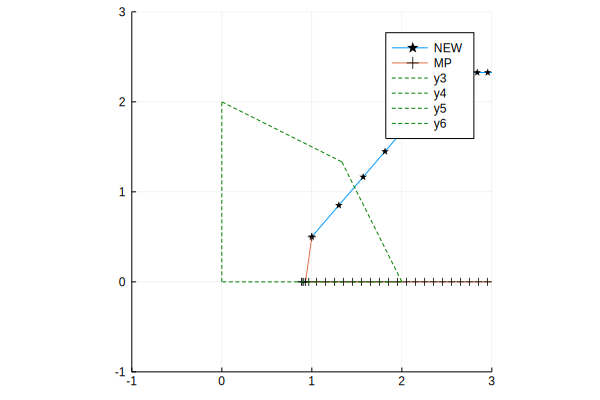

In [128]:
plot!(solutions_egd[1,:], solutions_egd[2,:], markershape=:+, markercolor=:black, axis=true, label="MP")
plot!([0,0],[0,2], linestyle=:dash, linecolor=:green)
plot!([0,4/3],[2,4/3], linestyle=:dash, linecolor=:green)
plot!([4/3,2],[4/3,0], linestyle=:dash, linecolor=:green)
plot!([2,0],[0,0], linestyle=:dash, linecolor=:green)
xlims!((-1,3))
ylims!((-1,3))

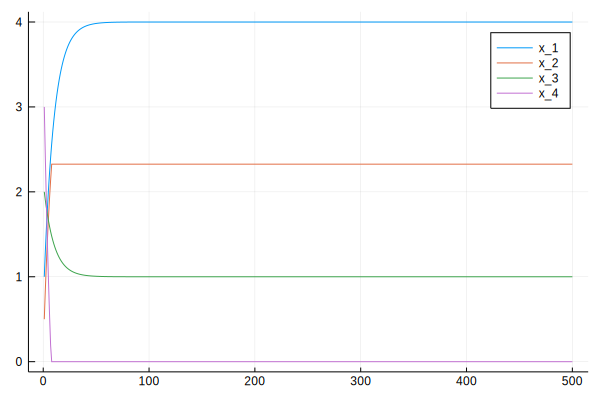

In [126]:
plot(solutions_new[1,:], label="x_1")
plot!(solutions_new[2,:], label="x_2")
plot!(solutions_new[3,:], label="x_3")
plot!(solutions_new[4,:], label="x_4")

In [59]:
a=1
for i in 1:100000
    a = a + 1/a
end
print(a)

447.22195789401366